# Week 12 Homework (HW10)


## Q1: define

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

## Q1 Answer

**Stochastic Processes:** A stochastic process is a collection of random variables, usually indexed by time or space (like $\{X_t\}$ where $t$ is time). I think of it as generating random functions or paths over time/space. Examples are things like random walks or stock price movements over time.

**Gaussian Processes (GPs):** A Gaussian Process is a specific kind of stochastic process where *any* set of points you pick from the process follows a joint Gaussian distribution. It's completely defined by:
1.  **Mean Function $m(x)$:** The average value of the process at input $x$. Often just set to zero.
2.  **Covariance Function (Kernel) $k(x, x')$:** Measures how related the process values are at two points $x$ and $x'$. This kernel encodes our assumptions about the function (e.g., how smooth it is). Common examples are RBF (Squared Exponential) or Matérn kernels.

Essentially, a GP defines a *prior distribution over functions*. In Bayesian modeling, we update this prior with data to get a posterior distribution over functions, giving us predictions and uncertainty estimates. They're useful for non-parametric regression.

**Variational Inference (VI) & ELBO:** Variational Inference is a way to approximate a complex posterior distribution $p(\theta|y)$ (which is often hard to calculate directly, especially in complex models) when MCMC is too slow. Instead of sampling, VI turns it into an optimization problem.
1.  We choose a simpler family of distributions (like Gaussians), called the variational family $q(\theta; \phi)$, parameterized by $\phi$.
2.  We try to find the distribution $q^*$ in this family that's closest to the true posterior $p(\theta|y)$, usually by minimizing the KL divergence $KL(q || p)$.

Minimizing this KL divergence is equivalent to maximizing the **Evidence Lower Bound (ELBO)**:
$$ \text{ELBO}(\phi) = \underbrace{E_{q(\theta; \phi)}[\log p(y|\theta)]}_{\text{How well } q \text{ explains the data}} - \underbrace{KL(q(\theta; \phi) || p(\theta))}_{\text{How close } q \text{ is to the prior}} $$
The first term pushes $q$ towards parameters that fit the data well, while the second term acts like a regularizer, keeping $q$ close to the prior $p(\theta)$. Since $\log p(y) \ge \text{ELBO}(\phi)$, maximizing the ELBO gets our approximation $q$ as close as possible to the true posterior $p(\theta|y)$ within the limits of the chosen family. VI is often faster than MCMC but the quality of the approximation depends on how well the chosen family $q$ can match the true posterior.

## Q2: more Gaussian Processes

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

## Q2 Answer


Loading and preparing sunspot data...
Data shape: (109, 1), (109,)
Original Mean: 60.08, Original Std Dev: 47.68
Time range: 1900.00 to 2008.00


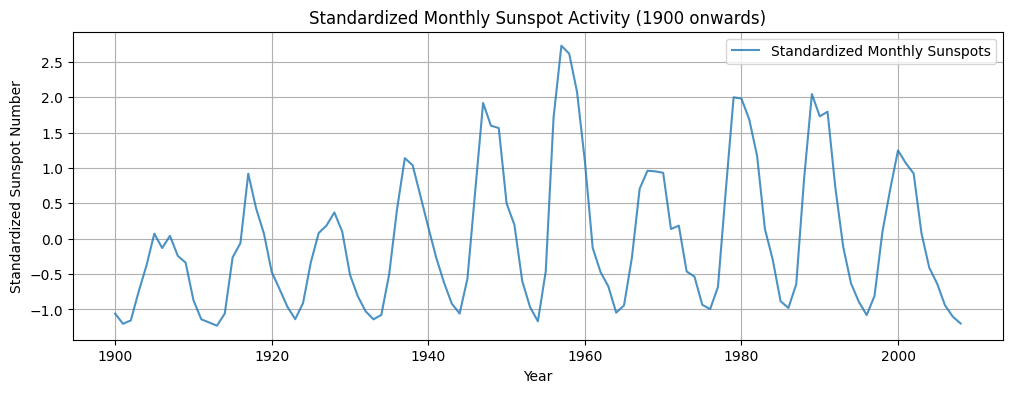

In [1]:
# Import necessary libraries
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import statsmodels.api as sm
import pandas as pd

# 1. Load and Prepare the Sunspot Data
print("Loading and preparing sunspot data...")
sunspots_data = sm.datasets.sunspots.load_pandas().data

# --- CORRECTED DATA PREPARATION ---
# The 'YEAR' column is already the time axis we need (float year)
# Set 'YEAR' as the index
sunspots_data = sunspots_data.set_index('YEAR')

# Handle potential missing values (e.g., fill forward, interpolate, or drop)
# Let's use linear interpolation for simplicity here
sunspots_data['SUNACTIVITY'] = sunspots_data['SUNACTIVITY'].interpolate(method='linear')
# Drop any remaining NaNs at the beginning/end if interpolation didn't cover them
sunspots_data = sunspots_data.dropna(subset=['SUNACTIVITY'])

# Select subset (e.g., 1900 onwards)
sunspots_subset = sunspots_data[sunspots_data.index >= 1900].copy()

# --- Standardize the target variable ---
y_mean = sunspots_subset['SUNACTIVITY'].mean()
y_std = sunspots_subset['SUNACTIVITY'].std()
sunspots_subset['SUNACTIVITY_std'] = (sunspots_subset['SUNACTIVITY'] - y_mean) / y_std

# Prepare data for PyMC
X_time = sunspots_subset.index.values[:, None] # Input features (time, already float year)
y_observed_std = sunspots_subset['SUNACTIVITY_std'].values # Standardized target

print(f"Data shape: {X_time.shape}, {y_observed_std.shape}")
print(f"Original Mean: {y_mean:.2f}, Original Std Dev: {y_std:.2f}")
print(f"Time range: {X_time.min():.2f} to {X_time.max():.2f}")


# Plot the standardized data being used
plt.figure(figsize=(12, 4))
plt.plot(X_time, y_observed_std, label='Standardized Monthly Sunspots', alpha=0.8)
plt.xlabel('Year')
plt.ylabel('Standardized Sunspot Number')
plt.title('Standardized Monthly Sunspot Activity (1900 onwards)')
plt.legend()
plt.grid(True)
plt.show()

**Model Definition:**
*   **Priors:** We define `HalfCauchy` and `Gamma` priors for the amplitudes (`η`) and lengthscales (`ℓ`) of the kernel components, and the noise (`σ`). A key prior is `pm.Normal("period", mu=11.0, sigma=1.5)` for the period of the `Periodic` kernel, strongly centering it around the known 11-year cycle but allowing the data to adjust it slightly.
*   **Mean Function:** A `Constant` mean of 0 is used because the data was standardized.
*   **Kernel:** The core is the combined kernel `cov_total = cov_periodic + cov_local`.
    *   `pm.gp.cov.Periodic`: Captures the main ~11-year cycle. Its shape is controlled by `ℓ_periodic`.
    *   `pm.gp.cov.Matern32`: Models the shorter-term, less smooth variations *on top of* the main cycle. `Matern32` is chosen over `ExpQuad` (RBF) as sunspot activity can sometimes have slightly sharper changes than RBF implies. Its influence range is controlled by `ℓ_local`.
    *   The amplitudes `η_periodic` and `η_local` (squared in the kernel definition) control the contribution of each component.
*   **GP Specification:** `pm.gp.Marginal` integrates out the latent GP function, which is efficient for Gaussian likelihoods.
*   **Likelihood:** The `marginal_likelihood` connects the GP to the standardized observations `y_observed_std` with noise level `σ`.

In [2]:
# 2. Define the Gaussian Process Model in PyMC
with pm.Model() as gp_sunspot_model:
    # --- Priors for GP hyperparameters ---

    # Periodic Component
    η_periodic = pm.HalfCauchy("η_periodic", beta=1, initval=1.0) # Amplitude
    ℓ_periodic = pm.Gamma("ℓ_periodic", alpha=3, beta=1)       # Lengthscale (smoothness of periodic shape)
    period = pm.Normal("period", mu=11.0, sigma=1.5)           # Period (strong prior around 11 years)
    # Short-term/Local variations Component (using Matern 3/2 for less smoothness than RBF)
    η_local = pm.HalfCauchy("η_local", beta=0.5, initval=0.5) # Amplitude
    ℓ_local = pm.Gamma("ℓ_local", alpha=2, beta=2)        # Lengthscale (how quickly local variations change)

    # Observation Noise
    σ = pm.HalfCauchy("σ", beta=0.5, initval=0.1)

    # --- Mean Function ---
    # Constant mean (overall average level, model learns deviations)
    mean_func = pm.gp.mean.Constant(c=0.0) # Centered at 0 due to standardization

    # --- Covariance Function (Kernel) ---
    # Combine periodic and local variations
    # Periodic Kernel
    cov_periodic = η_periodic**2 * pm.gp.cov.Periodic(input_dim=1, period=period, ls=ℓ_periodic)
    # Local Kernel (Matern 3/2)
    cov_local = η_local**2 * pm.gp.cov.Matern32(input_dim=1, ls=ℓ_local)
    # Total Covariance = Periodic + Local Effects
    cov_total = cov_periodic + cov_local

    # --- Specify the GP ---
    # Use Marginal implementation (suitable for Gaussian likelihood)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_total)

    # --- Likelihood ---
    # Connect GP to observed (standardized) data with noise sigma
    y_ = gp.marginal_likelihood("y_", X=X_time, y=y_observed_std, sigma=σ)

    # --- Inference ---
    print("Starting MCMC sampling...")
    # NUTS sampler
    idata_gp_sunspots = pm.sample(target_accept=0.95)

Starting MCMC sampling...


Output()

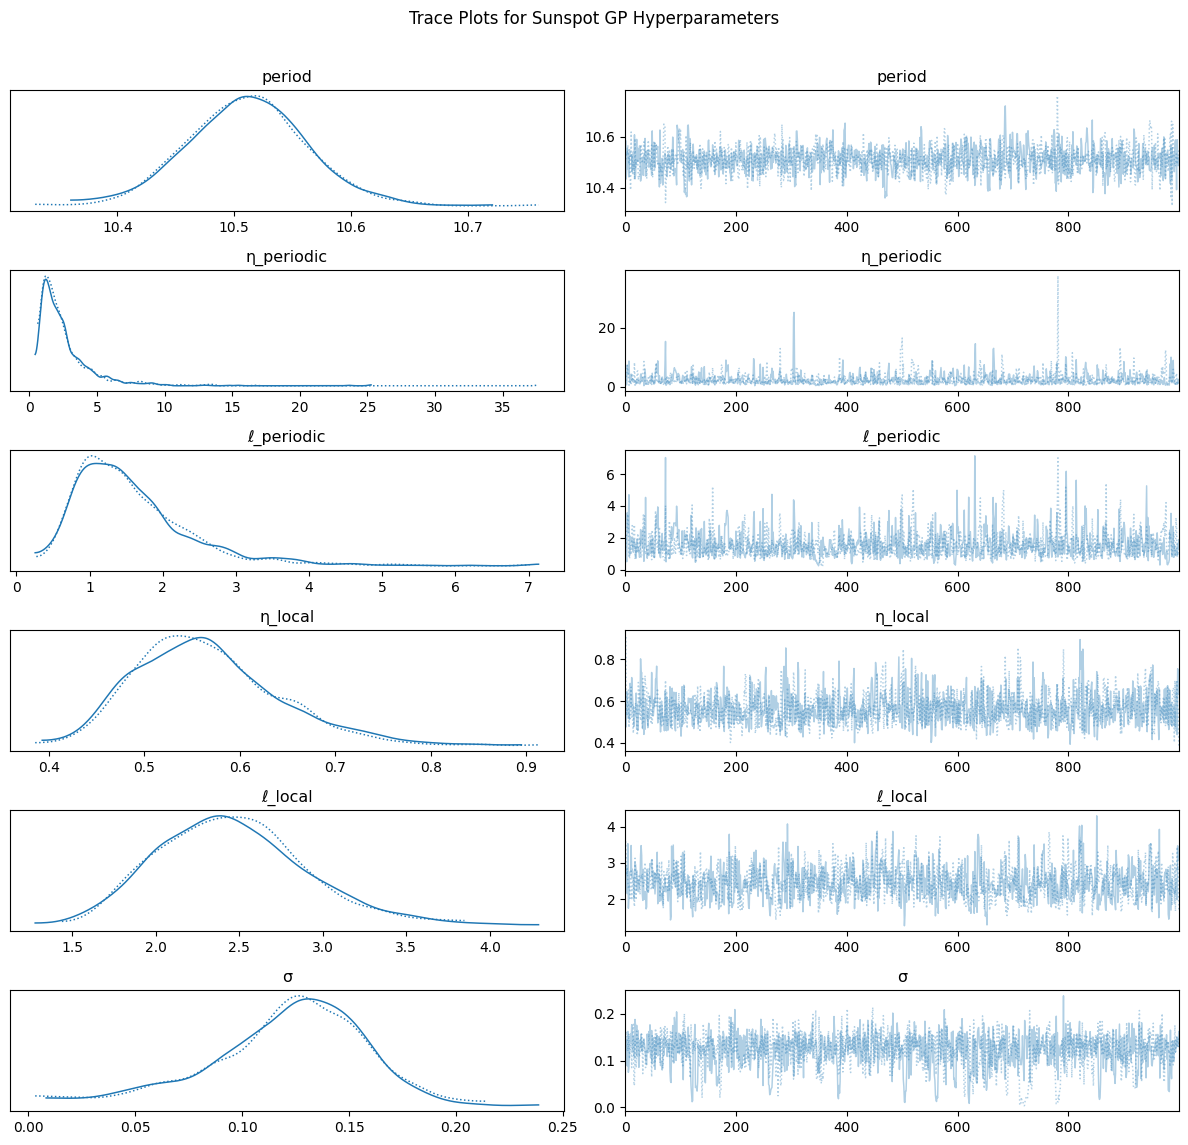

In [3]:
# 3. Analyze Results
# Check trace plots for key hyperparameters
az.plot_trace(idata_gp_sunspots, var_names=["period", "η_periodic", "ℓ_periodic", "η_local", "ℓ_local", "σ"]);
plt.suptitle("Trace Plots for Sunspot GP Hyperparameters")
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout
plt.show()

In [4]:
az.summary(idata_gp_sunspots, var_names=["period", "η_periodic", "ℓ_periodic", "η_local", "ℓ_local", "σ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,10.511,0.051,10.422,10.614,0.001,0.002,1492.0,1116.0,1.0
η_periodic,2.558,2.175,0.493,5.944,0.068,0.199,1084.0,1210.0,1.0
ℓ_periodic,1.575,0.813,0.375,2.993,0.025,0.031,1026.0,882.0,1.0
η_local,0.566,0.075,0.442,0.713,0.002,0.002,1415.0,964.0,1.0
ℓ_local,2.458,0.442,1.706,3.337,0.015,0.011,819.0,966.0,1.0
σ,0.121,0.037,0.045,0.185,0.002,0.002,636.0,330.0,1.0


**Prediction:** `gp.conditional` is used to get the predictive distribution on a new time grid (`X_new`) that extends into the future. `pm.sample_posterior_predictive` draws samples from this distribution.

In [5]:
# 4. Predict on a new grid including the future
print("Generating predictions...")
# Grid for prediction (extend 2 cycles into the future)
future_years = 2 * 11
X_new = np.linspace(X_time.min(), X_time.max() + future_years, 250)[:, None]

with gp_sunspot_model:
    # Use gp.conditional for prediction
    gp_pred_std = gp.conditional("gp_pred_std", Xnew=X_new)
    # Sample from posterior predictive distribution
    idata_gp_sunspots.extend(pm.sample_posterior_predictive(idata_gp_sunspots, var_names=["gp_pred_std"], random_seed=125))

Generating predictions...


Output()

**Visualization:** The posterior predictive mean and a 95% credible interval (mean +/- 2 std dev) are calculated. These predictions (which are on the standardized scale) are transformed back to the original sunspot number scale using the saved `y_mean` and `y_std`. The plot shows the original data, the mean prediction, and the uncertainty band, clearly illustrating the model's fit and its forecasts. The estimated mean period is also printed.

Visualizing predictions...


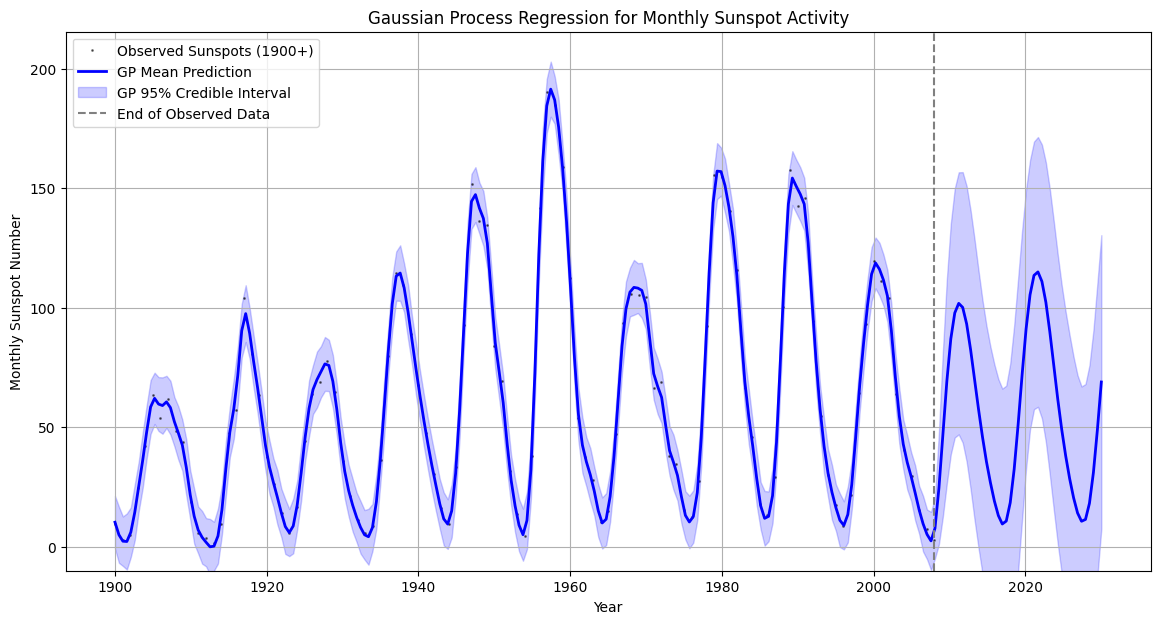


Estimated Mean Period: 10.51 years


In [6]:
# 5. Visualize Predictions (Rescaled to Original Sunspot Numbers)
print("Visualizing predictions...")
plt.figure(figsize=(14, 7))

# Extract predictions (standardized scale)
posterior_predictive_std = idata_gp_sunspots.posterior_predictive["gp_pred_std"] # Shape: (chains, draws, timepoints)
pred_mean_std = posterior_predictive_std.mean(dim=("chain", "draw")).values
pred_std_std = posterior_predictive_std.std(dim=("chain", "draw")).values

# --- De-standardize predictions ---
pred_mean_orig = (pred_mean_std * y_std) + y_mean
pred_lower_orig = ((pred_mean_std - 2 * pred_std_std) * y_std) + y_mean
pred_upper_orig = ((pred_mean_std + 2 * pred_std_std) * y_std) + y_mean

# Plot observed data (original scale)
plt.plot(X_time, (y_observed_std * y_std) + y_mean, 'k.', markersize=2, alpha=0.5, label='Observed Sunspots (1900+)')

# Plot GP prediction (original scale)
plt.plot(X_new, pred_mean_orig, 'b-', lw=2, label='GP Mean Prediction')
plt.fill_between(X_new.flatten(),
                 pred_lower_orig,
                 pred_upper_orig,
                 color='blue', alpha=0.2, label='GP 95% Credible Interval')

plt.axvline(X_time.max(), color='gray', linestyle='--', label='End of Observed Data')
plt.xlabel("Year")
plt.ylabel("Monthly Sunspot Number")
plt.title("Gaussian Process Regression for Monthly Sunspot Activity")
plt.legend(loc='upper left')
plt.grid(True)
plt.ylim(bottom=-10) # Ensure y-axis starts below 0
plt.show()

# Display estimated period
estimated_period = idata_gp_sunspots.posterior['period'].mean().item()
print(f"\nEstimated Mean Period: {estimated_period:.2f} years")

## Q3: more Variational Inference/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.



## Q3 Answer

In [11]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import seaborn as sns
import pandas as pd # Added for potential future data loading

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

# Configuration
floatX = pytensor.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# 1. Load and Prepare the Breast Cancer Dataset
print("Loading and preparing Breast Cancer dataset...")
cancer = load_breast_cancer()
X_data = cancer.data.astype(floatX)
y_data = cancer.target.astype(floatX)
feature_names = cancer.feature_names

print(f"Original data shape: {X_data.shape}")
print(f"Target distribution: {np.bincount(y_data.astype(int))}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, y_data, test_size=0.3, random_state=RANDOM_SEED, stratify=y_data
)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Loading and preparing Breast Cancer dataset...
Original data shape: (569, 30)
Target distribution: [212 357]
Training data shape: (398, 30)
Test data shape: (171, 30)


In [16]:
# 2. Model Specification Function
def construct_bnn_cancer_nomc(X_train_data, Y_train_data, n_hidden=10): # Removed batch_size
    """Constructs the Bayesian Neural Network model using PyMC (no minibatches)."""
    n_features = X_train_data.shape[1]
    n_output = 1

    init_1 = rng.standard_normal(size=(n_features, n_hidden)).astype(floatX) * 0.1
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX) * 0.1
    init_out = rng.standard_normal(size=(n_hidden, n_output)).astype(floatX) * 0.1

    coords = {
        "input_feature": feature_names,
        "hidden_layer_1_node": np.arange(n_hidden),
        "hidden_layer_2_node": np.arange(n_hidden),
        "output_node": ["output"],
        "observation": np.arange(X_train_data.shape[0]), # Observation dim needed for likelihood
    }

    with pm.Model(coords=coords) as neural_network:
        # --- Use pm.Data for input data ---
        # Makes it potentially mutable if needed later, though prediction func handles test data
        ann_input = pm.Data("ann_input", X_train_data, dims=("observation", "input_feature"), mutable=True)

        # --- Priors ---
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("input_feature", "hidden_layer_1_node")
        )
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1_node", "hidden_layer_2_node")
        )
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims=("hidden_layer_2_node", "output_node"))

        # --- Network Logic ---
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out_linear = pm.math.dot(act_2, weights_2_out)
        act_out = pm.math.sigmoid(act_out_linear)

        # --- Likelihood ---
        # Observed is now the full Y_train_data
        # No total_size needed
        out = pm.Bernoulli(
            "out",
            act_out.flatten(),
            observed=Y_train_data, # Pass full training labels
            dims="observation"      # Match observation dimension
        )
    print("Model constructed.")
    return neural_network

# Construct the simplified model
bnn_cancer_nomc = construct_bnn_cancer_nomc(X_train, Y_train, n_hidden=10)

Model constructed.


/usr/local/lib/python3.11/dist-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


Starting ADVI...


Output()

ADVI fitting complete.


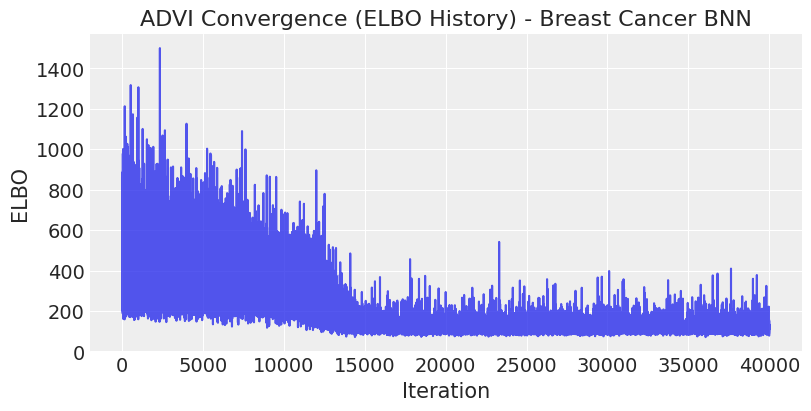

In [17]:
print("Starting ADVI...")
with bnn_cancer_nomc:
    approx = pm.fit(n=40000, method='advi', random_seed=RANDOM_SEED)

print("ADVI fitting complete.")

# Plot ELBO
plt.figure(figsize=(8, 4))
plt.plot(approx.hist, alpha=0.8)
plt.ylabel("Negative ELBO" if approx.hist[0] < 0 else "ELBO")
plt.xlabel("Iteration")
plt.title("ADVI Convergence (ELBO History) - Breast Cancer BNN")
plt.grid(True)
plt.show()

In [18]:
print("Sampling from VI approximation...")
trace_cancer = approx.sample(draws=2000, random_seed=RANDOM_SEED)

Sampling from VI approximation...


In [19]:
# 4. Posterior Predictive Check on Test Set
def sample_posterior_predictive_cancer(X_test_data, Y_test_data, trace, n_hidden=10):
    """Generates posterior predictive samples using the trace from VI."""
    n_features = X_test_data.shape[1]
    n_output = 1

    coords_pred = {
        "input_feature": feature_names[:n_features],
        "hidden_layer_1_node": np.arange(n_hidden),
        "hidden_layer_2_node": np.arange(n_hidden),
        "output_node": ["output"],
        "observation_pred": np.arange(X_test_data.shape[0]), # Prediction dimension
    }

    with pm.Model(coords=coords_pred) as neural_network_pred:
        # --- Placeholders for weights ---
        weights_in_1 = pm.Flat("w_in_1", shape=(n_features, n_hidden), dims=("input_feature", "hidden_layer_1_node"))
        weights_1_2 = pm.Flat("w_1_2", shape=(n_hidden, n_hidden), dims=("hidden_layer_1_node", "hidden_layer_2_node"))
        weights_2_out = pm.Flat("w_2_out", shape=(n_hidden, n_output), dims=("hidden_layer_2_node", "output_node"))

        # --- Network Logic ---
        ann_input = pm.ConstantData("ann_input_pred", X_test_data) # Use ConstantData for fixed test input
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out_linear = pm.math.dot(act_2, weights_2_out)
        act_out = pm.math.sigmoid(act_out_linear)

        # --- Likelihood (for sampling predictive outcomes) ---
        out = pm.Bernoulli("out", act_out.flatten(), observed=Y_test_data, dims="observation_pred")

        print("Generating posterior predictive samples...")
        ppc = pm.sample_posterior_predictive(trace, var_names=['out'], random_seed=RANDOM_SEED)

        # --- Manual Probability Calculation ---
        ppc_probs = {}
        w1_samples = trace.posterior["w_in_1"].values.reshape(-1, n_features, n_hidden)
        w12_samples = trace.posterior["w_1_2"].values.reshape(-1, n_hidden, n_hidden)
        w2o_samples = trace.posterior["w_2_out"].values.reshape(-1, n_hidden, n_output)

        n_samples_total = w1_samples.shape[0]
        pred_probs_all_samples = np.zeros((n_samples_total, X_test_data.shape[0]))

        print(f"Calculating probabilities manually using {n_samples_total} posterior samples...")
        for i in range(n_samples_total):
             act1_i = np.tanh(np.dot(X_test_data, w1_samples[i]))
             act2_i = np.tanh(np.dot(act1_i, w12_samples[i]))
             act_out_linear_i = np.dot(act2_i, w2o_samples[i])
             pred_probs_all_samples[i, :] = 1 / (1 + np.exp(-act_out_linear_i.flatten())) # Sigmoid

        ppc_probs['out_prob'] = pred_probs_all_samples

    return ppc, ppc_probs

# Generate predictions (make sure n_hidden matches model construction)
ppc_cancer, ppc_cancer_probs = sample_posterior_predictive_cancer(X_test, Y_test, trace_cancer, n_hidden=10)

/usr/local/lib/python3.11/dist-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Generating posterior predictive samples...


Output()

Calculating probabilities manually using 2000 posterior samples...


In [20]:
# 5. Evaluate Performance
pred_labels = ppc_cancer.posterior_predictive["out"].mean(("chain", "draw")) > 0.5
test_accuracy = (Y_test == pred_labels.values).mean()
print(f"\nTest Set Accuracy: {test_accuracy * 100:.2f}%")

pred_probs_mean = ppc_cancer_probs['out_prob'].mean(axis=0)
fpr, tpr, thresholds = roc_curve(Y_test, pred_probs_mean)
roc_auc = auc(fpr, tpr)
print(f"Test Set ROC AUC: {roc_auc:.4f}")


Test Set Accuracy: 97.08%
Test Set ROC AUC: 0.9981


Visualizing performance with ROC curve...


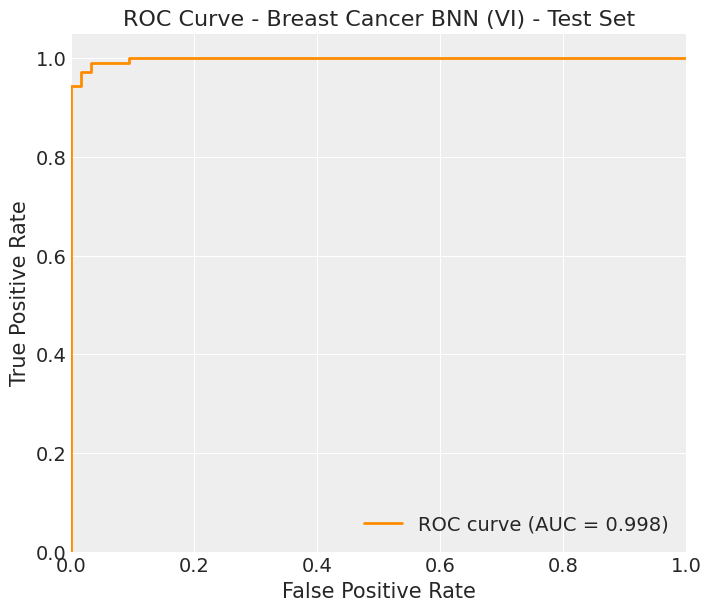

In [22]:
# 6. Visualize Performance (ROC Curve)
print("Visualizing performance with ROC curve...")
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Breast Cancer BNN (VI) - Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

array([[<Axes: title={'center': 'w_in_1'}>,
        <Axes: title={'center': 'w_in_1'}>]], dtype=object)

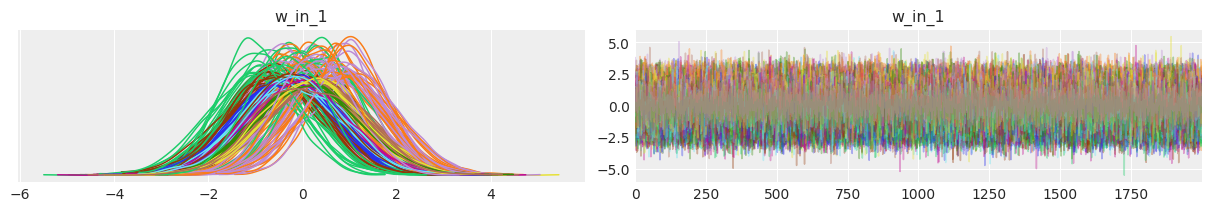

In [23]:
# just for fun, doesn't matter
az.plot_trace(trace_cancer, var_names=['w_in_1'])